# MACS 30200

PS2

Jie Heng

4/30/2018

In [143]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns; sns.set()
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import gaussian_kde
import pandas as pd
import statsmodels.api as sm
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import LeaveOneOut
from sklearn.neighbors import KernelDensity
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import timeit

## Problem 1

### a

In [144]:
bq_data = np.loadtxt('data/BQmat_orig.txt', delimiter=',')
bq_data.shape

(78, 7)

In [145]:
lambdas = np.array([0.25, 0.25, 0.20, 0.10, 0.10, 0.09, 0.01])
lambdas_mdpts = np.array([0.125, 0.375, 0.60, 0.75, 0.85,
                          0.94, 0.995])
ages_vec = np.arange(18, 96)

Text(0.5,0,'Density')

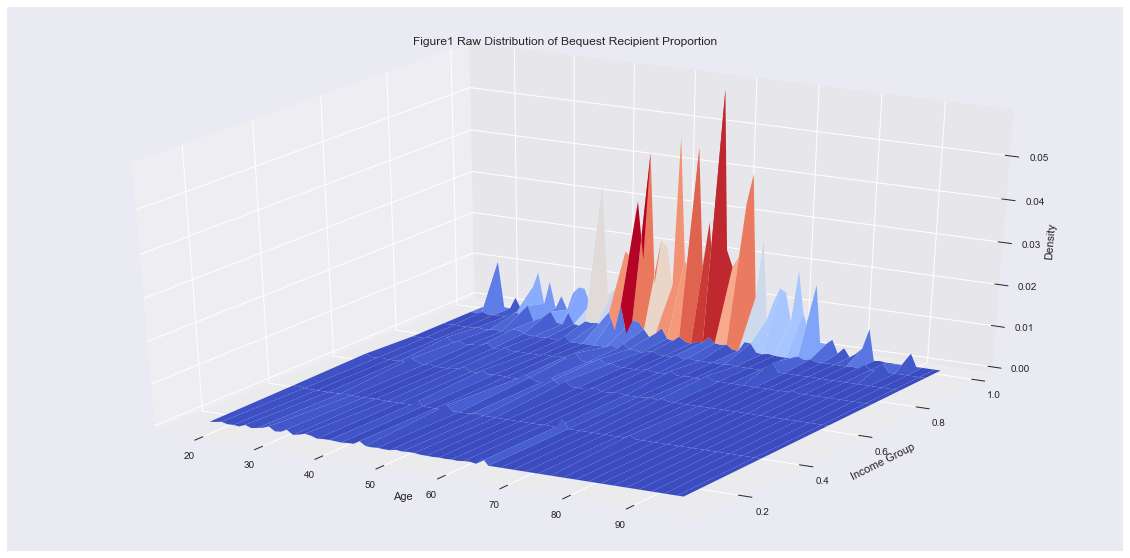

In [146]:
y_mat, x_mat = np.meshgrid(lambdas_mdpts, ages_vec)
fig = plt.figure(figsize=(20,10))
ax = fig.gca(projection='3d')
ax.plot_surface(x_mat, y_mat, bq_data, cmap=cm.coolwarm, )
plt.title("Figure1 Raw Distribution of Bequest Recipient Proportion")
plt.xlabel("Age")
plt.ylabel("Income Group")
ax.set_zlabel("Density")

### b

In [147]:
bandwidths = 10 ** np.linspace(-1, 1, 100)
grid = GridSearchCV(KernelDensity(kernel='gaussian'),
                    {'bandwidth': bandwidths},
                    cv=LeaveOneOut(len(bq_data)))
grid.fit(bq_data);

In [148]:
#  find the choice of bandwidth which maximizes the score
grid.best_params_

{'bandwidth': 0.1}

The best bandwidth is 0.1.

In [149]:
bandwidth = 0.1
abils_midpt = lambdas_mdpts

# proportions of each income and age_group 
prop_mat_inc = np.sum(bq_data, axis=0)
prop_mat_age = np.sum(bq_data, axis=1)

# set some large sample
lrg_samp = 70000

# random distributions out of 70000 sample
age_probs = np.random.multinomial(lrg_samp, prop_mat_age)
# print(age_probs)
income_probs = np.random.multinomial(lrg_samp, prop_mat_inc)
# print(income_probs)

age_freq = np.array([])
inc_freq = np.array([])

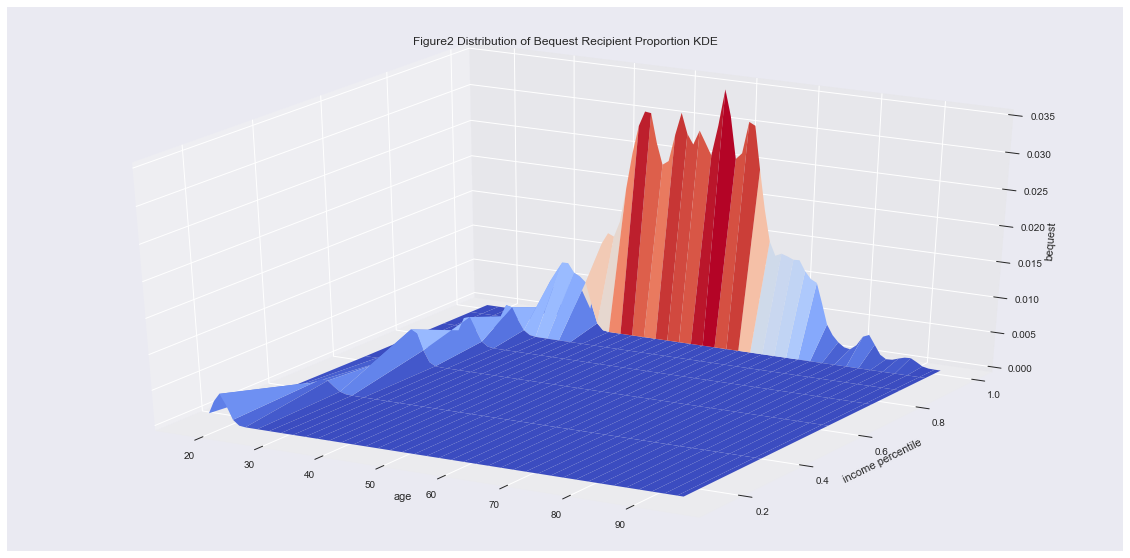

In [150]:
# creating a distribution of age values
for age, num_s in zip(ages_vec, age_probs):
    vec_age_s = np.ones(num_s)
    vec_age_s *= age
    age_freq = np.append(age_freq, vec_age_s)

# creating a distribution of ability type values
for abil, num_j in zip(lambdas_mdpts, income_probs):
    vec_abil_j = np.ones(num_j)
    vec_abil_j *= abil
    inc_freq = np.append(inc_freq, vec_abil_j)

data = np.vstack((age_freq, inc_freq))
density = gaussian_kde(data, bw_method=grid.best_params_["bandwidth"])


ages_mat, abils_mat=np.meshgrid(ages_vec,lambdas_mdpts)

coords = np.vstack([item.ravel() for item in [ages_mat, abils_mat]])
BQkde = density(coords).reshape(ages_mat.shape)
BQkde_scaled = BQkde / BQkde.sum()
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('age')
ax.set_ylabel('income percentile')
ax.set_zlabel('bequest')
ax.set_title('Figure2 Distribution of Bequest Recipient Proportion KDE')
ax.plot_surface(ages_mat, abils_mat, BQkde_scaled, cmap=cm.coolwarm, )

In [151]:
est = BQkde_scaled[5, 61-18+1]
print('The estimated density for bequest recipients who are age 61 in the 6th lifetime income category is', est)

The estimated density for bequest recipients who are age 61 in the 6th lifetime income category is 1.0850373665923437e-06


## Problem 2

### a

In [152]:
df=pd.read_csv("data/biden.csv")
df.head()

,biden,female,age,educ,dem,rep
0,90.0,0,19.0,12.0,1.0,0.0
1,70.0,1,51.0,14.0,1.0,0.0
2,60.0,0,27.0,14.0,0.0,0.0
3,50.0,1,43.0,14.0,1.0,0.0
4,60.0,1,38.0,14.0,0.0,1.0


In [153]:
df['age_edu']=df.age*df.educ
df['const']=1
X=df[['age','educ','age_edu','const']]
y=df.biden
model = sm.OLS(y, X, missing='drop').fit()
predictions = model.predict(X)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  biden   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     10.13
Date:                Mon, 30 Apr 2018   Prob (F-statistic):           1.29e-06
Time:                        11:26:39   Log-Likelihood:                -8333.3
No. Observations:                1826   AIC:                         1.667e+04
Df Residuals:                    1822   BIC:                         1.670e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
age            0.6674      0.169      3.950      0.000       0.336       0.999
educ           1.7123      0.709      2.414      0.016       0.321       3.103
age_edu       -0.0477      0.013     -3.728      0.000      -0.073      -0.023
const         37.5491      9.491      3.956      0.000      18.935      56.163
==============================================================================
Omnibus:                       64.792   Durbin-Watson:                   1.974
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               70.979
Skew:                          -0.480   Prob(JB):                     3.86e-16
Kurtosis:                       3.105   Cond. No.                     1.19e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.19e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

From the table, we have the equation: biden = 37.5491 + 0.6674*age + 1.7123*educ - 0.0477*age$*$educ

C:\Users\hengj\Anaconda_3\lib\site-packages\numpy\core\_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)


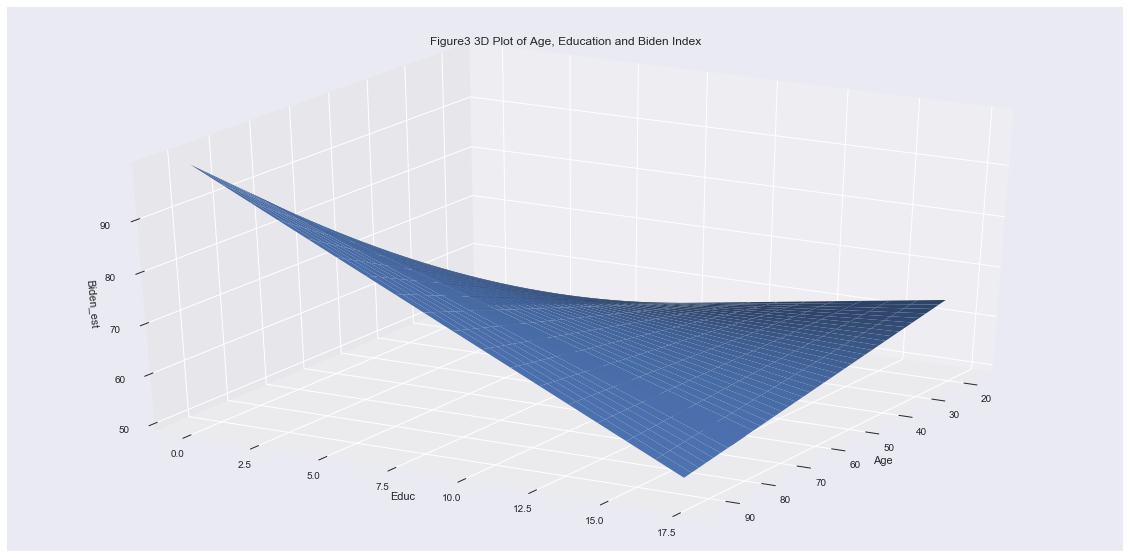

In [154]:
age_vals = np.array(sorted(df.age.unique()))
educ_vals = np.array(sorted(df.educ.unique()))
myeduc, myage = np.meshgrid(educ_vals, age_vals)
mybiden = 37.5491 + 0.6674*myage + 1.7123*myeduc - 0.0477*myage*myeduc
fig = plt.figure(figsize=(20,10))
ax = fig.gca(projection='3d')
ax.plot_surface(age1, educ1, mybiden)
plt.title("Figure3 3D Plot of Age, Education and Biden Index")
plt.xlabel("Age")
plt.ylabel("Educ")
ax.set_zlabel("Biden_est")
ax.view_init(30, 30)
plt.show()
plt.pause(.001)

In [155]:
0.6674/0.0477

13.9916142557652

When educ increases to 13.9916142557652, we will expect the change of direction of marginal effect.

The effect is significant at 0.001 level.

The marginal effect of age is $\beta_1+\beta_3 X_2$. The marginal effect of 'age' on Biden sentiment is $0.67 - 0.048\sf{educ}$.If educ is 0, then the marginal effect of age on Biden sentiment is 0.6674. And one unit increases in educ will lead to about 0.048 decrease of the effect of age on biden. The effect of age on biden feelings changes from positive to negative when education increases to about 14. 

### b

C:\Users\hengj\Anaconda_3\lib\site-packages\numpy\core\_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)


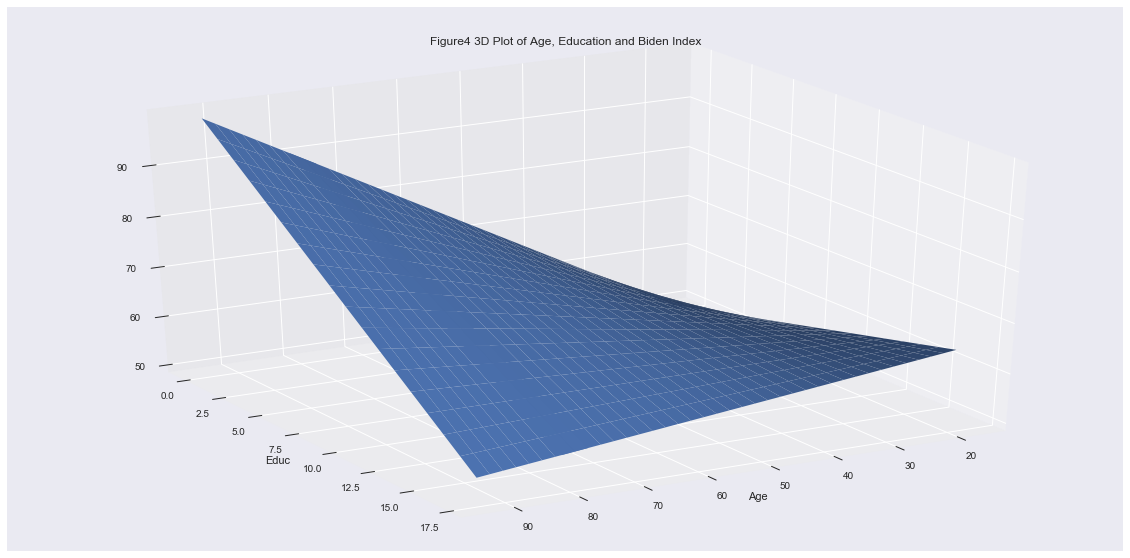

In [156]:
fig = plt.figure(figsize=(20,10))
ax = fig.gca(projection='3d')
ax.plot_surface(myage, myeduc, mybiden)
plt.title("Figure4 3D Plot of Age, Education and Biden Index")
plt.xlabel("Age")
plt.ylabel("Educ")
ax.view_init(30, 60)
plt.show()
plt.pause(.001)

In [157]:
1.7123/0.0477

35.897274633123686

When age increases to 35.897274633123686, we will expect the change of direction of marginal effect.

The effect is significant at 0.05 level.

The marginal effect of education is $\beta_2+\beta_3 X_1$, and the estimated effect is $1.71-0.048 age$. If age is 0 than the marginal effect of educ on Biden sentiment is 1.7123. And one unit increases in age will lead to about 0.048 decrease of the effect of educ on biden. The effect of education on biden feelings changes from positive to negative when age increases to about 36. 